In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
import os
from IPython.display import clear_output
import random


=== GRILLE DE CLIFF WALKING ===
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  .  .  . 
 S  ■  ■  ■  ■  ■  ■  ■  ■  ■  ■  G 

Legende:
  S = Start (état 0)
  G = Goal (état 47)
  ■ = Cliff (récompense -100 si tombé)
  . = Terrain sûr (récompense -1)

=== TRAJECTOIRE FINALE SARSA ===
Récompense totale : -15
États visités : [36, 24, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 35, 47]

=== TRAJECTOIRE FINALE Q-LEARNING ===
Récompense totale : -13
États visités : [36, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 47]


C:\Users\medel\AppData\Local\Temp\ipykernel_1080\2301680598.py:176: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


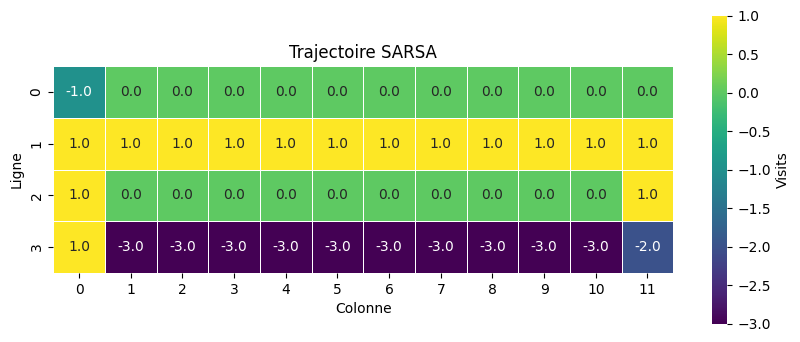

C:\Users\medel\AppData\Local\Temp\ipykernel_1080\2301680598.py:176: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis').copy()


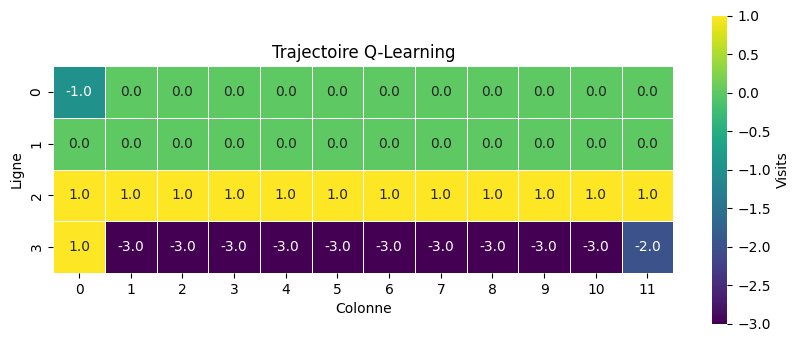

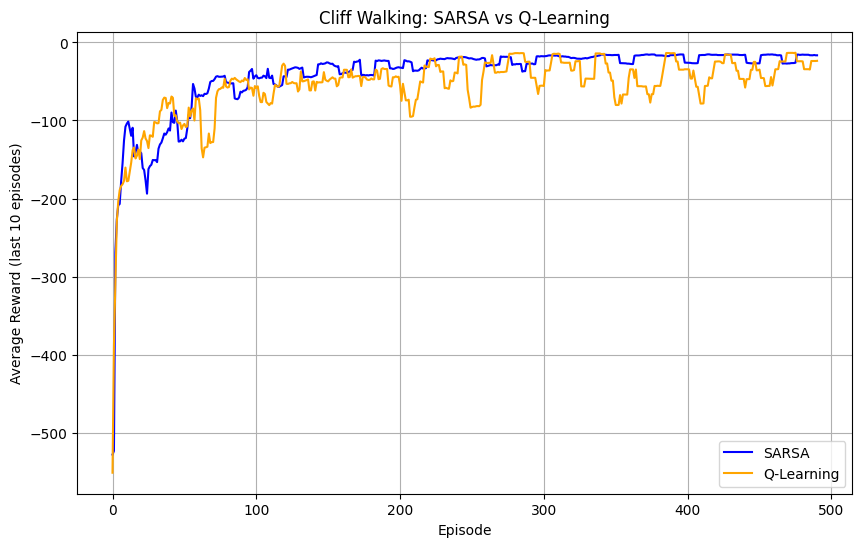

In [ ]:


# --- ENVIRONNEMENT CLIFF WALKING (v1) ---
env = gym.make('CliffWalking-v1')

# --- PARAMÈTRES COMMUNS ---
n_episodes = 500
alpha = 0.1
gamma = 0.9
epsilon = 0.1
epsilon_decay = 0.0001
rng = np.random.default_rng()

# Initialisation des tables Q
q_sarsa = np.zeros((env.observation_space.n, env.action_space.n))
q_qlearn = np.zeros((env.observation_space.n, env.action_space.n))

# Stockage des récompenses
rewards_sarsa = np.zeros(n_episodes)
rewards_qlearn = np.zeros(n_episodes)

# Fonction pour choisir une action selon ε-greedy
def choose_action(q_table, state, epsilon, rng):
    if rng.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state, :])

# --- ENTRAÎNEMENT SARSA ---
epsilon_current = epsilon

for episode in range(n_episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0

    action = choose_action(q_sarsa, state, epsilon_current, rng)

    while not terminated and not truncated:
        new_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        next_action = choose_action(q_sarsa, new_state, epsilon_current, rng)

        q_sarsa[state, action] += alpha * (
            reward + gamma * q_sarsa[new_state, next_action] - q_sarsa[state, action]
        )

        state = new_state
        action = next_action

    rewards_sarsa[episode] = total_reward
    epsilon_current = max(epsilon_current - epsilon_decay, 0)

# --- ENTRAÎNEMENT Q-LEARNING ---
epsilon_current = epsilon

for episode in range(n_episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0

    while not terminated and not truncated:
        action = choose_action(q_qlearn, state, epsilon_current, rng)
        new_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        q_qlearn[state, action] += alpha * (
            reward + gamma * np.max(q_qlearn[new_state, :]) - q_qlearn[state, action]
        )

        state = new_state

    rewards_qlearn[episode] = total_reward
    epsilon_current = max(epsilon_current - epsilon_decay, 0)

# --- FONCTION POUR AFFICHER LA GRILLE AVEC S, G ET CLIFF ---
def display_grid_with_paths(q_sarsa, q_qlearn, env):
    # Grille 4x12
    rows, cols = 4, 12
    grid = np.full((rows, cols), ' ')  # Fond vide

    # Positions spéciales
    start_pos = (3, 0)   # Bas gauche
    goal_pos = (3, 11)   # Bas droite
    cliff_row = 3
    cliff_start = 1
    cliff_end = 10

    # Marquer S, G et Cliff
    grid[start_pos] = 'S'
    grid[goal_pos] = 'G'
    for c in range(cliff_start, cliff_end + 1):
        grid[cliff_row, c] = 'X'  # X = Cliff

    print("\n=== GRILLE DE CLIFF WALKING ===")
    for r in range(rows):
        row_str = ""
        for c in range(cols):
            if grid[r, c] == 'X':
                row_str += " ■ "  # Cliff
            elif grid[r, c] == 'S':
                row_str += " S "
            elif grid[r, c] == 'G':
                row_str += " G "
            else:
                row_str += " . "
        print(row_str)

    print("\nLegende:")
    print("  S = Start (état 0)")
    print("  G = Goal (état 47)")
    print("  ■ = Cliff (récompense -100 si tombé)")
    print("  . = Terrain sûr (récompense -1)")

# --- FONCTION POUR SIMULER UNE TRAJECTOIRE FINALE ---
def simulate_trajectory(q_table, env, render=False):
    state, _ = env.reset()
    trajectory = [state]
    terminated = False
    truncated = False
    total_reward = 0

    while not terminated and not truncated:
        action = np.argmax(q_table[state, :])
        new_state, reward, terminated, truncated, _ = env.step(action)
        trajectory.append(new_state)
        total_reward += reward
        state = new_state

        if render:
            env.render()

    return trajectory, total_reward

# --- AFFICHAGE DE LA GRILLE ---
display_grid_with_paths(q_sarsa, q_qlearn, env)

# --- SIMULATION DES TRAJECTOIRES FINALES ---
print("\n=== TRAJECTOIRE FINALE SARSA ===")
traj_sarsa, reward_sarsa = simulate_trajectory(q_sarsa, env)
print(f"Récompense totale : {reward_sarsa}")
print(f"États visités : {traj_sarsa}")

print("\n=== TRAJECTOIRE FINALE Q-LEARNING ===")
traj_qlearn, reward_qlearn = simulate_trajectory(q_qlearn, env)
print(f"Récompense totale : {reward_qlearn}")
print(f"États visités : {traj_qlearn}")

# --- VISUALISATION DES CHEMINS SUR LA GRILLE ---
def plot_path_on_grid(trajectory, title, env):
    rows, cols = 4, 12
    grid = np.zeros((rows, cols))  # Matrice de chaleur pour les visites

    # Marquer les états visités
    for state in trajectory:
        r, c = divmod(state, cols)
        grid[r, c] += 1

    # Créer une copie pour affichage
    display_grid = np.copy(grid)
    # Mettre en évidence S, G et Cliff
    start_r, start_c = divmod(0, cols)
    goal_r, goal_c = divmod(47, cols)
    display_grid[start_r, start_c] = -1  # S
    display_grid[goal_r, goal_c] = -2     # G
    for c in range(1, 11):
        display_grid[3, c] = -3           # Cliff

    plt.figure(figsize=(10, 4))
    cmap = plt.cm.get_cmap('viridis').copy()
    cmap.set_under('red')     # Cliff
    cmap.set_over('blue')     # Start
    cmap.set_bad('green')     # Goal

    sns.heatmap(display_grid, annot=True, fmt="", cmap=cmap, linewidths=.5,
                cbar_kws={'label': 'Visits'}, square=True,
                xticklabels=[f"{i}" for i in range(cols)],
                yticklabels=[f"{i}" for i in range(rows)])

    plt.title(title)
    plt.xlabel("Colonne")
    plt.ylabel("Ligne")
    plt.show()

plot_path_on_grid(traj_sarsa, "Trajectoire SARSA", env)
plot_path_on_grid(traj_qlearn, "Trajectoire Q-Learning", env)

# --- TRACÉ DES RÉCOMPENSES ---
plt.figure(figsize=(10,6))
plt.plot(np.convolve(rewards_sarsa, np.ones(10)/10, mode='valid'), label='SARSA', color='blue')
plt.plot(np.convolve(rewards_qlearn, np.ones(10)/10, mode='valid'), label='Q-Learning', color='orange')
plt.title("Cliff Walking: SARSA vs Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Average Reward (last 10 episodes)")
plt.legend()
plt.grid(True)
plt.savefig('cliff_walking_comparison_v1.png')
plt.show()

In [14]:

def save_frames_as_gif(frames,episode, algorithm_type, path='./Algorithm_Animations/', filename='gym_animation.gif'):
    #Mess with this to change frame size
    print(frames[0].shape)
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')
    plt.title(f"Run from episode {episode} {algorithm_type}")

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=30)

In [ ]:
nv = gym.make("CliffWalking-v1", render_mode="rgb_array")

ALPHA = 0.85
EPSILON = 0.1
EPISODES = 100
GAMMA = 0.99
RENDER_AT_EPISODE = 10

Q_table = np.zeros((env.observation_space.n, env.action_space.n))

episode_frames_SARSA = {}
sum_rewards = {}
time_step = 0

# =============================
# SARSA TRAINING
# =============================
for episode in range(EPISODES):
    
    observation, info = env.reset()
    rewards = 0
    frames = []
    done = False

    # -------- SELECT a USING ε-GREEDY ----------
    if random.random() < EPSILON:
        action = random.randint(0, env.action_space.n - 1)
    else:
        action = np.argmax(Q_table[observation])

    while not done:
        
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # -------- SELECT next_action USING ε-GREEDY ----------
        if random.random() < EPSILON:
            next_action = random.randint(0, env.action_space.n - 1)
        else:
            next_action = np.argmax(Q_table[next_observation])

        # -------- SARSA UPDATE ----------
        td_target = reward + GAMMA * Q_table[next_observation][next_action]
        td_error  = td_target - Q_table[observation][action]
        
        Q_table[observation][action] += ALPHA * td_error

        # -------- TRANSITION ----------
        observation = next_observation
        action = next_action
        rewards += reward
        time_step += 1

        # -------- RENDER ----------
        if episode % RENDER_AT_EPISODE == 0:
            clear_output(wait=True)
            frame = env.render()
            frames.append(frame)
            plt.imshow(frame)
            plt.axis("off")
            plt.title(f"SARSA Episode {episode}")
            plt.show()

    # SAVE REWARDS
    sum_rewards[episode] = rewards

    # SAVE GIF
    if episode % RENDER_AT_EPISODE == 0:
        frames += [frame, frame]  # add a few still frames
        episode_frames_SARSA[episode] = frames
        save_frames_as_gif(frames, episode, "SARSA", filename=f"SARSA episode {episode}.gif")

In [ ]:
# THIS IS FOR Q-LEARNING
env = gym.make('CliffWalking-v1',render_mode="rgb_array")

ALPHA = 0.85
EPSILON = 0.1
RENDER_AT_EPISODE = 10
EPISODES = 100
LEARNING_RATE = 0.99
alpha = np.linspace(0.01,0.99,10)
learning_rate= np.linspace(0.01,0.99,10)

episode_frames_Q = {}
time_step=0
sum_of_rewards = {}

Q_table = np.zeros((env.observation_space.n,env.action_space.n)) #THIS NEEDS TO BE A TABLE FOR EACH STATE AND ACTION
for episode in range(EPISODES): #for each episode
    observation,info = env.reset() #initialize the environment
    done=False
    rewards = 0
    frames=[]
    while not done: #for each time step
        # SELECT AN ACTION USING EPSILON GREEDY METHOD
        #if random.random() < EPSILON:
        #    action = random.randint(0,env.action_space.n-1)
        #else: 
        action = np.argmax(Q_table[observation])

        next_observation, reward, done, truncated,info = env.step(action) #take an action and get feedback from the environment
        Q_table[observation][action] = Q_table[observation][action] + ALPHA*(reward + LEARNING_RATE*np.max(Q_table[next_observation]) - Q_table[observation][action])
        observation = next_observation
        time_step+=1
        rewards+=reward
        if episode%RENDER_AT_EPISODE == 0:
            clear_output(wait=True)
            single_frame = env.render()
            frames.append(single_frame)
            plt.imshow(single_frame)
            plt.show()
    sum_of_rewards[episode] = rewards
    if episode%RENDER_AT_EPISODE == 0:
        frames.append(single_frame)
        frames.append(single_frame)
        episode_frames_Q[episode] = frames
        save_frames_as_gif(frames,episode,"Q-Learning",filename=f"Q-Learning episode {episode}.gif")